In [67]:
#Importing necessary libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.font_manager as fm 
import datetime as dt   
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from imblearn.over_sampling import SMOTE 
from collections import Counter  
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import xgboost as xgb

In [68]:
#ระบุ font ที่ต้องการใช้ในการแสดงผล 
font_name = 'TH Sarabun new' 
font_found = False #flag variable

#ตรวจสอบว่า font ที่ต้องการใช้มีอยู่หรือไม่
#กรณีหาเจอ

for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    try:
        f = fm.FontProperties(fname=font) #สร้าง object ของ font
        if font_name.lower() in f.get_name().lower():
            font_found = True
            print(f'Using font: {font_name}') 
            break
    except:
        pass 

#กรณีหาไม่เจอ 
if not font_found:
    print(f"Warning: Font '{font_name}' not found. Trying common font names...")

    #ลองหา font อื่นๆ ที่อาจจะมีในระบบ 
    font_name_more = ['Leelawadee UI','Tahoma','Cordia New','Thonburi','Sarasara']
    for fonts in font_name_more:
        for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
           try:
                f = fm.FontProperties(fname=font)
                if fonts.lower() in f.get_name().lower():
                    font_name = fonts
                    font_found = True 
                    print(f'Using font: {fonts}') 
                    break 
           except:
               pass 
        if font_found:
                break
#กรณีที่หาไม่เจอทั้งใน font ที่กำหนดและ font อื่นๆ ที่พบเจอ
if not font_found:
    print(f"Warning: Font '{font_name}' not found. Using default font 'Arial'.")
    font_name = 'Arial' 

#ตั้งค่า font ให้เป็น font เริ่มต้น สำหรับ matplotlip 
plt.rcParams['font.family'] = font_name 
plt.rcParams['axes.unicode_minus'] = False  # ป้องกันปัญหาที่ font เป็นสี่เหลี่ยม

print(f'Matplotlib font now set to: {plt.rcParams["font.family"]}') 

Using font: Tahoma
Matplotlib font now set to: ['Tahoma']


In [69]:
Spodify_dataset = pd.read_csv('Spodify dataset 2025.csv') 

# Display basic information about the dataset
print('Dataset loaded successfully.')
print('Shape of dataset:', Spodify_dataset.shape)
print('Columns in dataset:', Spodify_dataset.columns)

Dataset loaded successfully.
Shape of dataset: (8000, 12)
Columns in dataset: Index(['user_id', 'gender', 'age', 'country', 'subscription_type',
       'listening_time', 'songs_played_per_day', 'skip_rate', 'device_type',
       'ads_listened_per_week', 'offline_listening', 'is_churned'],
      dtype='object')


#### Data Cleaning and Preprocessing 
In this section, we review the data for missing values and data type consistency. Although the dataset description suggests that the types are correct

In [70]:
# Quick check for missing values
missing_values = Spodify_dataset.isnull().sum()
print('Missing values in each column:')
print(missing_values)

# Data type verification
print('\nData Types:')
print(Spodify_dataset.dtypes)

Missing values in each column:
user_id                  0
gender                   0
age                      0
country                  0
subscription_type        0
listening_time           0
songs_played_per_day     0
skip_rate                0
device_type              0
ads_listened_per_week    0
offline_listening        0
is_churned               0
dtype: int64

Data Types:
user_id                    int64
gender                    object
age                        int64
country                   object
subscription_type         object
listening_time             int64
songs_played_per_day       int64
skip_rate                float64
device_type               object
ads_listened_per_week      int64
offline_listening          int64
is_churned                 int64
dtype: object


### Group data

In [71]:
#Group country
country_region_map = {
    "CA": "North America",
    "US": "North America",
    "DE": "Europe",
    "UK": "Europe",
    "FR": "Europe",
    "IN": "Asia",
    "PK": "Asia",
    "AU": "Oceania"
}

Spodify_dataset["region"] = Spodify_dataset["country"].map(country_region_map) 
Spodify_dataset 

#Group age 
bins = [0, 17, 24, 34, 44, 54, 100]
labels = ['teen','Young adult','Adult','Mid-career adults','Older adults','Seniors']
Spodify_dataset['age_groups'] = pd.cut(Spodify_dataset['age'], bins=bins, labels=labels)


#### Exploratory Data Analysis

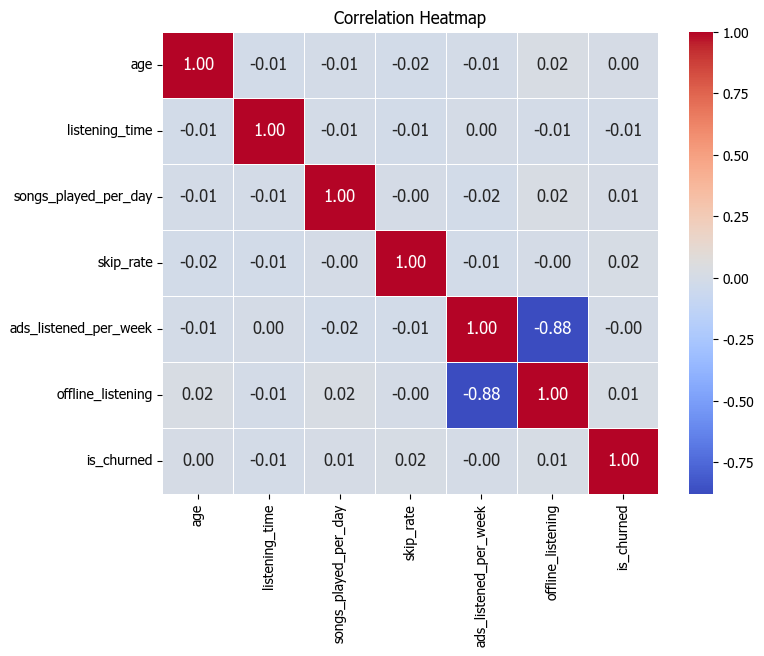

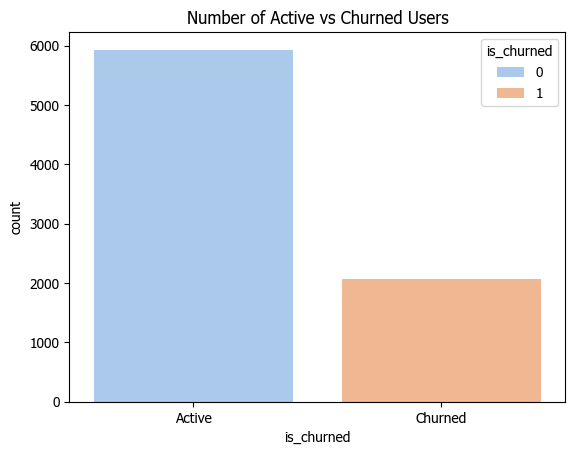

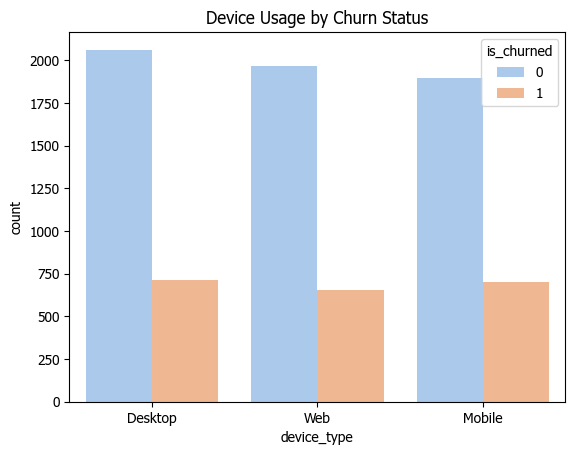

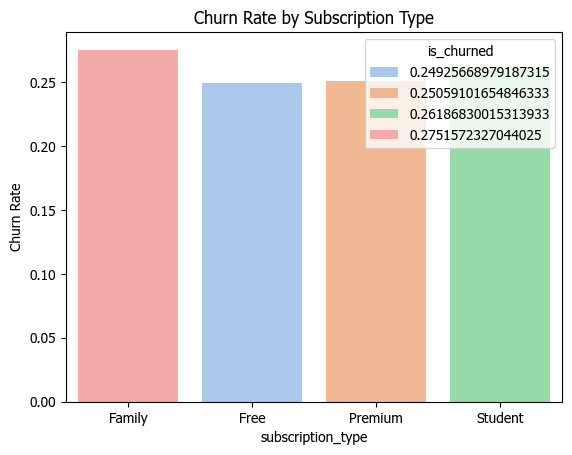

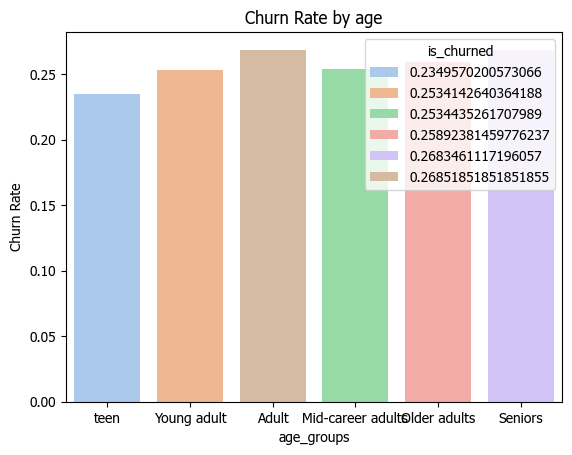

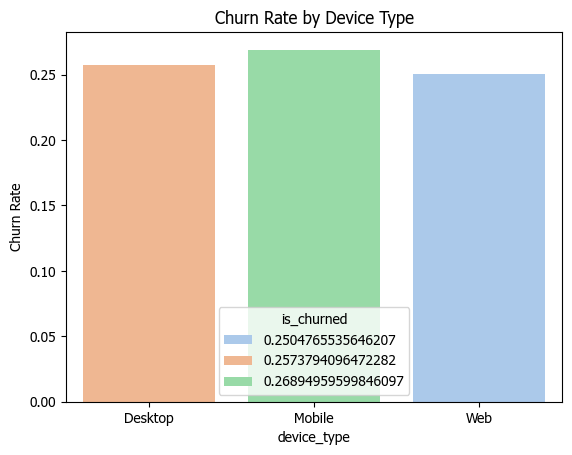

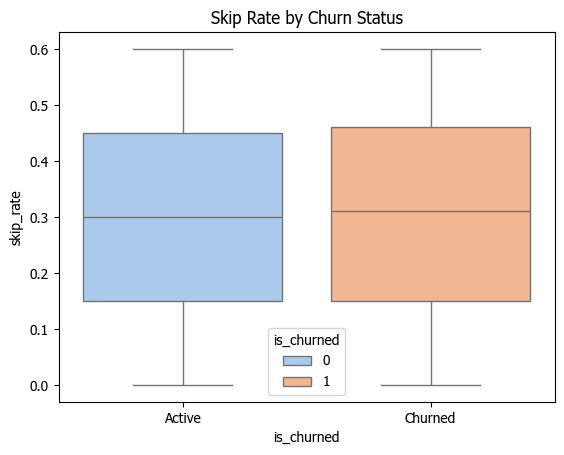

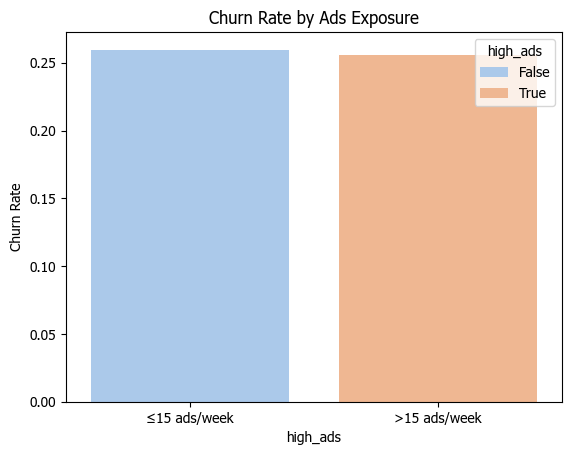

In [72]:
# List of numeric columns (excluding 'user_id' as it is an identifier) 
numeric_cols = ['age', 'listening_time', 'songs_played_per_day', 'skip_rate', 'ads_listened_per_week', 'offline_listening', 'is_churned'] 
numeric_df = Spodify_dataset[numeric_cols] 

corr = numeric_df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr,annot=True,fmt='.2f',cmap='coolwarm',linewidths=0.5,annot_kws={'size':12})
plt.title('Correlation Heatmap')
plt.show() 

sns.countplot(x='is_churned',data=Spodify_dataset,hue='is_churned',palette='pastel')
plt.xticks([0,1],['Active','Churned'])
plt.title('Number of Active vs Churned Users') 
plt.xticks([0,1],['Active','Churned'])
plt.show() 

sns.countplot(x='device_type', hue='is_churned', data=Spodify_dataset, palette='pastel')
plt.title('Device Usage by Churn Status')
plt.show()

churn_by_sub = Spodify_dataset.groupby('subscription_type')['is_churned'].mean().reset_index()
sns.barplot(x='subscription_type', y='is_churned', data=churn_by_sub ,hue='is_churned',palette='pastel')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Subscription Type')
plt.show() 

churn_by_age = Spodify_dataset.groupby('age_groups',observed=True)['is_churned'].mean().reset_index()
plt.Figure(figsize=(10,8))
sns.barplot(x='age_groups', y='is_churned', data=churn_by_age ,hue='is_churned',palette='pastel')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by age')
plt.show() 

churn_by_device = Spodify_dataset.groupby('device_type')['is_churned'].mean().reset_index()
sns.barplot(x='device_type', y='is_churned', data=churn_by_device,hue='is_churned',palette='pastel')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Device Type')
plt.show() 

sns.boxplot(x='is_churned', y='skip_rate', data=Spodify_dataset,hue='is_churned',palette='pastel')
plt.xticks([0,1], ['Active', 'Churned'])
plt.title('Skip Rate by Churn Status')
plt.show()

Spodify_dataset['high_ads'] = Spodify_dataset['ads_listened_per_week'] > 15
churn_by_ads = Spodify_dataset.groupby('high_ads')['is_churned'].mean().reset_index()
sns.barplot(x='high_ads', y='is_churned', data=churn_by_ads,hue='high_ads',palette='pastel')
plt.xticks([0,1], ['≤15 ads/week', '>15 ads/week'])
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Ads Exposure')
plt.show()


#### Prepare the data for ML

In [73]:
#Create Feature Engineering
Spodify_dataset['song_skipped'] = Spodify_dataset['songs_played_per_day'] * Spodify_dataset['skip_rate']
Spodify_dataset['high_skip'] = (Spodify_dataset['skip_rate'] > 0.5).astype(int) 
Spodify_dataset['low_listening'] = (Spodify_dataset['listening_time'] < 30).astype(int)
Spodify_dataset['ads_burden'] = (Spodify_dataset['ads_listened_per_week']/(Spodify_dataset['listening_time'] + 1))
Spodify_dataset['engagement_score'] = (Spodify_dataset['listening_time'] + Spodify_dataset['songs_played_per_day']) - Spodify_dataset['song_skipped'] 


In [74]:
#for visualization
Spodify_dataset_vi = Spodify_dataset
one_hot_encoded_vi_df = pd.get_dummies(data=Spodify_dataset,columns=['gender','subscription_type','device_type','region','age_groups'], drop_first=False)
#normalize numeric data 
numeric_features = ['listening_time','songs_played_per_day','song_skipped','offline_listening','ads_burden','engagement_score']
scaler = MinMaxScaler()
Spodify_dataset[numeric_features] = scaler.fit_transform(Spodify_dataset[numeric_features]) 

In [75]:
#drop country column because we use region instead
df_temp = Spodify_dataset.drop('country', axis=1)

#one-hot encoding
one_hot_encoded_df = pd.get_dummies(data=df_temp,columns=['gender','subscription_type','device_type','region','age_groups'], drop_first=True) 

#change bool to int 
bool_cols = one_hot_encoded_df.select_dtypes(include='bool').columns
one_hot_encoded_df[bool_cols] = one_hot_encoded_df[bool_cols].astype(int)
one_hot_encoded_vi_df[bool_cols] = one_hot_encoded_vi_df[bool_cols].astype(int)

In [76]:
#เนื่องจากกราฟ Number of Active vs Churned Users บอกให้เรารู้ว่าเกิด Imbalanced Data 
#ให้เราทำการ Oversampling หรือ Undersampling ด้วย SMOTE (Synthetic Minority Oversampling Technique
features_df = one_hot_encoded_df.drop('is_churned',axis=1) 
target_series = one_hot_encoded_df['is_churned']
# สมมติว่า X คือ Features และ y คือ Target (is_churned)
print("จำนวนข้อมูลก่อนทำ SMOTE:", Counter(target_series)) 

# สร้าง SMOTE object 
smote = SMOTE(random_state=42)

# ใช้ SMOTE เพื่อ Oversample ข้อมูล 
X_res , Y_res = smote.fit_resample(features_df,target_series) 

print("จำนวนข้อมูลหลังทำ SMOTE:", Counter(Y_res))

จำนวนข้อมูลก่อนทำ SMOTE: Counter({0: 5929, 1: 2071})
จำนวนข้อมูลหลังทำ SMOTE: Counter({1: 5929, 0: 5929})


In [77]:
#ทำการแบ่งข้อมูลเป็น training data และ test data
#นำข้อมูล training data มาใช้ training model
#นำข้อมูล test data มาใช้ test model  

X_train, X_test, Y_train , Y_test = train_test_split(X_res,Y_res,test_size=0.3,random_state=42)
print("ขนาดของ X_train:", X_train.shape)
print("ขนาดของ X_test:", X_test.shape)
print("ขนาดของ y_train:", Y_train.shape)
print("ขนาดของ y_test:", Y_test.shape)

ขนาดของ X_train: (8300, 28)
ขนาดของ X_test: (3558, 28)
ขนาดของ y_train: (8300,)
ขนาดของ y_test: (3558,)


## Predictive Analysis and Machine Learning 

#### LogisticRegression

In [ ]:
# Instantiate and train the logistic regression model
log_reg = LogisticRegression(random_state=42,max_iter=1000,solver='liblinear')
log_reg.fit(X_train,Y_train)

In [79]:
# Make predictions 
Y_pred = log_reg.predict(X_test) 
Y_train_pred_log = log_reg.predict(X_train)

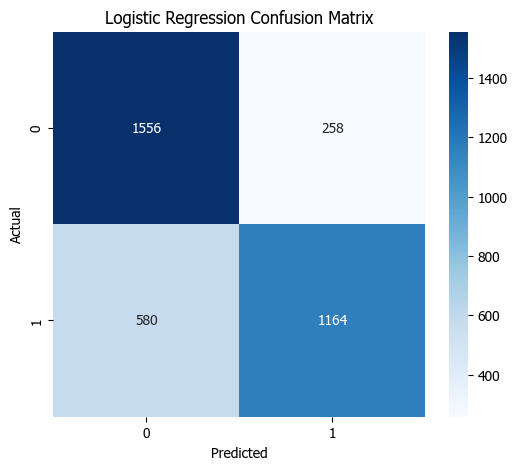


--- Training Set Performance ---
Logistic Accuracy: 0.76
Logistic Precision: 0.82
Logistic Recall: 0.66
Logistic F1-Score: 0.73
Logistic ROC-AUC Score: 0.76
------------------------------
--- Test Set Performance ---
Logistic Accuracy: 0.76
Logistic Precision: 0.82
Logistic Recall: 0.67
Logistic F1-Score: 0.74
Logistic ROC-AUC Score: 0.76

Confusion Matrix:
[[1556  258]
 [ 580 1164]]


In [80]:
#สร้าง confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# คำนวณค่าเมตริกสำหรับข้อมูลชุดฝึก
accuracy_train_log = accuracy_score(Y_train, Y_train_pred_log)
precision_train_log = precision_score(Y_train, Y_train_pred_log)
recall_train_log = recall_score(Y_train, Y_train_pred_log)
f1_train_log = f1_score(Y_train, Y_train_pred_log)
roc_auc_train_log = roc_auc_score(Y_train,Y_train_pred_log)

# แสดงผลลัพธ์ของชุดข้อมูลฝึก
print("\n--- Training Set Performance ---")
print(f"Logistic Accuracy: {accuracy_train_log:.2f}")
print(f"Logistic Precision: {precision_train_log:.2f}")
print(f"Logistic Recall: {recall_train_log:.2f}")
print(f"Logistic F1-Score: {f1_train_log:.2f}")
print(f"Logistic ROC-AUC Score: {roc_auc_train_log:.2f}")
print("-" * 30)

# Evaluate the model accuracy 
accuracy_log = accuracy_score(Y_test,Y_pred)
precision_log = precision_score(Y_test,Y_pred) 
recall_log = recall_score(Y_test,Y_pred) 
f1_log = f1_score(Y_test,Y_pred)
roc_auc_log = roc_auc_score(Y_test,Y_pred) 

print("--- Test Set Performance ---")
print(f"Logistic Accuracy: {accuracy_log:.2f}")
print(f"Logistic Precision: {precision_log:.2f}")
print(f"Logistic Recall: {recall_log:.2f}")
print(f"Logistic F1-Score: {f1_log:.2f}")
print(f"Logistic ROC-AUC Score: {roc_auc_log:.2f}")
print("\nConfusion Matrix:")
print(cm)

#### RandomForest

In [ ]:
# สร้างโมเดล Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# ฝึกโมเดลด้วยชุดข้อมูล Training ที่ผ่านการทำ SMOTE แล้ว
rf_model.fit(X_train, Y_train)

In [82]:
Y_pred_rf = rf_model.predict(X_test) 
# ทำนายผลบนชุดข้อมูลฝึก
Y_train_pred_rf = rf_model.predict(X_train)

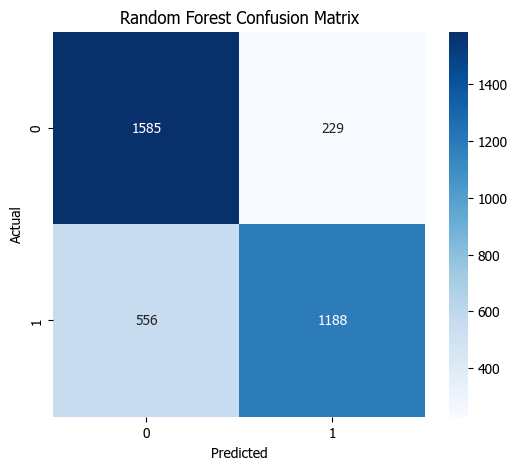


--- Training Set Performance ---
Random Forest Accuracy: 1.00
Random Forest Precision: 1.00
Random Forest Recall: 1.00
Random Forest F1-Score: 1.00
Random Forest ROC-AUC Score: 1.00
------------------------------
--- Test Set Performance ---
Random Forest Accuracy: 0.78
Random Forest Precision: 0.84
Random Forest Recall: 0.68
Random Forest F1-Score: 0.75
Random Forest ROC-AUC Score: 0.78

Random Forest Confusion Matrix:
[[1585  229]
 [ 556 1188]]


In [83]:
cm_rf = confusion_matrix(Y_test, Y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# คำนวณค่าเมตริกสำหรับข้อมูลชุดฝึก
accuracy_train_rf = accuracy_score(Y_train, Y_train_pred_rf)
precision_train_rf = precision_score(Y_train, Y_train_pred_rf)
recall_train_rf = recall_score(Y_train, Y_train_pred_rf)
f1_train_rf = f1_score(Y_train, Y_train_pred_rf)
roc_auc_train_rf = roc_auc_score(Y_train,Y_train_pred_rf)

# แสดงผลลัพธ์ของชุดข้อมูลฝึก
print("\n--- Training Set Performance ---")
print(f"Random Forest Accuracy: {accuracy_train_rf:.2f}")
print(f"Random Forest Precision: {precision_train_rf:.2f}")
print(f"Random Forest Recall: {recall_train_rf:.2f}")
print(f"Random Forest F1-Score: {f1_train_rf:.2f}")
print(f"Random Forest ROC-AUC Score: {roc_auc_train_rf:.2f}")
print("-" * 30)

accuracy_rf = accuracy_score(Y_test, Y_pred_rf)
precision_rf = precision_score(Y_test, Y_pred_rf)
recall_rf = recall_score(Y_test, Y_pred_rf)
f1_rf = f1_score(Y_test, Y_pred_rf)
roc_auc_rf = roc_auc_score(Y_test, Y_pred_rf)

print("--- Test Set Performance ---")
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print(f"Random Forest Precision: {precision_rf:.2f}")
print(f"Random Forest Recall: {recall_rf:.2f}")
print(f"Random Forest F1-Score: {f1_rf:.2f}")
print(f"Random Forest ROC-AUC Score: {roc_auc_rf:.2f}")
print("\nRandom Forest Confusion Matrix:")
print(cm_rf) 

#### XGBoost

In [ ]:
# n_estimators: จำนวนต้นไม้, learning_rate: ควบคุมขนาดขั้นตอนการปรับปรุงโมเดล
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
# ฝึกโมเดลด้วยชุดข้อมูล Training
xgb_model.fit(X_train, Y_train)

In [85]:
# ใช้โมเดลทำนายผลบนชุดข้อมูล Testing
Y_pred_xgb = xgb_model.predict(X_test) 
Y_train_pred_xgb = xgb_model.predict(X_train)

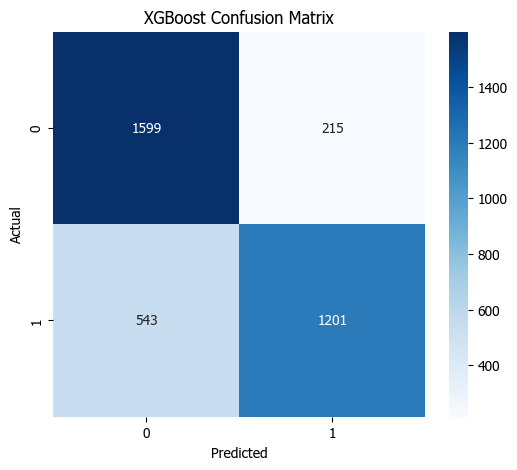


--- Training Set Performance ---
XGBoost Accuracy: 0.87
XGBoost Precision: 0.95
XGBoost Recall: 0.79
XGBoost F1-Score: 0.86
XGBoost ROC-AUC Score: 0.87
------------------------------
--- Test Set Performance ---
XGBoost Accuracy: 0.79
XGBoost Precision: 0.85
XGBoost Recall: 0.69
XGBoost F1-Score: 0.76
XGBoost ROC-AUC Score: 0.79

XGBoost Confusion Matrix:
[[1599  215]
 [ 543 1201]]


In [86]:
cm_xgb = confusion_matrix(Y_test, Y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# คำนวณค่าเมตริกสำหรับข้อมูลชุดฝึก
accuracy_train_xgb = accuracy_score(Y_train, Y_train_pred_xgb)
precision_train_xgb = precision_score(Y_train, Y_train_pred_xgb)
recall_train_xgb = recall_score(Y_train, Y_train_pred_xgb)
f1_train_xgb = f1_score(Y_train, Y_train_pred_xgb)
roc_auc_train_xgb = roc_auc_score(Y_train,Y_train_pred_xgb)

# แสดงผลลัพธ์ของชุดข้อมูลฝึก
print("\n--- Training Set Performance ---")
print(f"XGBoost Accuracy: {accuracy_train_xgb:.2f}")
print(f"XGBoost Precision: {precision_train_xgb:.2f}")
print(f"XGBoost Recall: {recall_train_xgb:.2f}")
print(f"XGBoost F1-Score: {f1_train_xgb:.2f}")
print(f"XGBoost ROC-AUC Score: {roc_auc_train_xgb:.2f}")
print("-" * 30)

accuracy_xgb = accuracy_score(Y_test, Y_pred_xgb)
precision_xgb = precision_score(Y_test, Y_pred_xgb)
recall_xgb = recall_score(Y_test, Y_pred_xgb)
f1_xgb = f1_score(Y_test, Y_pred_xgb)
roc_auc_xgb = roc_auc_score(Y_test, Y_pred_xgb)

print("--- Test Set Performance ---")
print(f"XGBoost Accuracy: {accuracy_xgb:.2f}")
print(f"XGBoost Precision: {precision_xgb:.2f}")
print(f"XGBoost Recall: {recall_xgb:.2f}")
print(f"XGBoost F1-Score: {f1_xgb:.2f}")
print(f"XGBoost ROC-AUC Score: {roc_auc_xgb:.2f}") 
print("\nXGBoost Confusion Matrix:")
print(cm_xgb)

## Hyperparameter Optimization

In [87]:
# กำหนดพารามิเตอร์ที่คุณต้องการทดสอบ (ในรูปแบบของช่วงค่า)
param_distributions = {
    'n_estimators': randint(100, 500), # สุ่มค่าระหว่าง 100 ถึง 500
    'learning_rate': uniform(0.01, 0.2), # สุ่มค่าระหว่าง 0.01 ถึง 0.2
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4), # ตัวเลือกเพิ่มเติม
    'colsample_bytree': uniform(0.6, 0.4)
}

# สร้างโมเดล XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)

# ใช้ RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50, # จำนวนรอบที่สุ่มหา
    cv=5,
    scoring='f1',
    random_state=42,
    verbose=1
)

# เริ่มการค้นหา
random_search.fit(X_train, Y_train)

# แสดงผลลัพธ์ที่ดีที่สุด
print("พารามิเตอร์ที่ดีที่สุด:", random_search.best_params_)
print("คะแนน F1-Score ที่ดีที่สุด:", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
พารามิเตอร์ที่ดีที่สุด: {'colsample_bytree': np.float64(0.610167650697638), 'learning_rate': np.float64(0.031578285398660894), 'max_depth': 9, 'n_estimators': 451, 'subsample': np.float64(0.8545641645055122)}
คะแนน F1-Score ที่ดีที่สุด: 0.7663893875837946


#### Best-in-Class Performance: XGBoost's Role in Predicting Churn

In [ ]:
# สร้างโมเดล XGBoost ด้วยพารามิเตอร์ที่ดีที่สุดที่ได้จาก Randomized Search
best_xgb_model = xgb.XGBClassifier(
    colsample_bytree=0.610167650697638,
    learning_rate=0.031578285398660894,
    max_depth=9,
    n_estimators=451,
    subsample=0.8545641645055122,
    random_state=42
) 
#ฝึกโมเดลด้วยชุดข้อมูล Training
best_xgb_model.fit(X_train, Y_train)

In [89]:
# ทำนายผลบนชุดข้อมูล Testing
Y_pred_best_xgb = best_xgb_model.predict(X_test) 
Y_train_pred_best_xgb = best_xgb_model.predict(X_train)


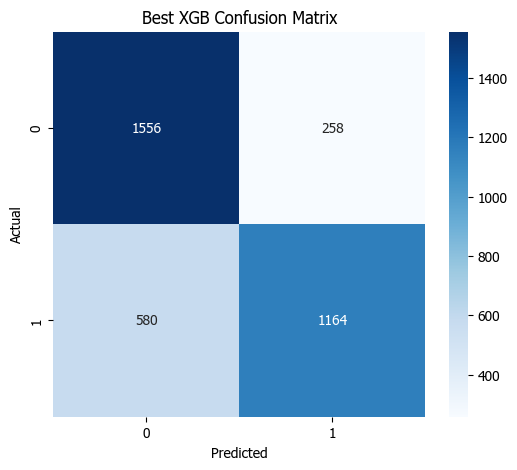


--- Training Set Performance ---
Best xgb Accuracy: 0.87
Best xgb Precision: 0.95
Best xgb Recall: 0.79
Best xgb F1-Score: 0.86
Best xgb ROC-AUC Score: 0.87
------------------------------
--- Test Set Performance ---
Best xgb Accuracy: 0.79
Best xgb Precision: 0.84
Best xgb Recall: 0.70
Best xgb F1-Score: 0.76
Best xgb ROC-AUC score:0.79

Best XGB Confusion Matrix:
[[1556  258]
 [ 580 1164]]


In [90]:
cm_best_xgb = confusion_matrix(Y_test, Y_pred) 
plt.figure(figsize=(6, 5))
sns.heatmap(cm_best_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('Best XGB Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 
# คำนวณค่าเมตริกสำหรับข้อมูลชุดฝึก
accuracy_train_best_xgb = accuracy_score(Y_train, Y_train_pred_best_xgb)
precision_train_best_xgb = precision_score(Y_train, Y_train_pred_best_xgb)
recall_train_best_xgb = recall_score(Y_train, Y_train_pred_best_xgb)
f1_train_best_xgb = f1_score(Y_train, Y_train_pred_best_xgb)
roc_auc_train_best_xgb = roc_auc_score(Y_train,Y_train_pred_best_xgb)

# แสดงผลลัพธ์ของชุดข้อมูลฝึก
print("\n--- Training Set Performance ---")
print(f"Best xgb Accuracy: {accuracy_train_xgb:.2f}")
print(f"Best xgb Precision: {precision_train_xgb:.2f}")
print(f"Best xgb Recall: {recall_train_xgb:.2f}")
print(f"Best xgb F1-Score: {f1_train_xgb:.2f}")
print(f"Best xgb ROC-AUC Score: {roc_auc_train_xgb:.2f}")
print("-" * 30)

accuracy_best_xgb = accuracy_score(Y_test, Y_pred_best_xgb)
precision_best_xgb = precision_score(Y_test, Y_pred_best_xgb)
recall_best_xgb = recall_score(Y_test, Y_pred_best_xgb)
f1_best_xgb = f1_score(Y_test, Y_pred_best_xgb)
roc_auc_best_xgb = roc_auc_score(Y_test,Y_pred_best_xgb)

print("--- Test Set Performance ---")
print(f"Best xgb Accuracy: {accuracy_best_xgb:.2f}")
print(f"Best xgb Precision: {precision_best_xgb:.2f}")
print(f"Best xgb Recall: {recall_best_xgb:.2f}")
print(f"Best xgb F1-Score: {f1_best_xgb:.2f}")
print(f"Best xgb ROC-AUC score:{roc_auc_best_xgb:.2f}")
print("\nBest XGB Confusion Matrix:")
print(cm_best_xgb)

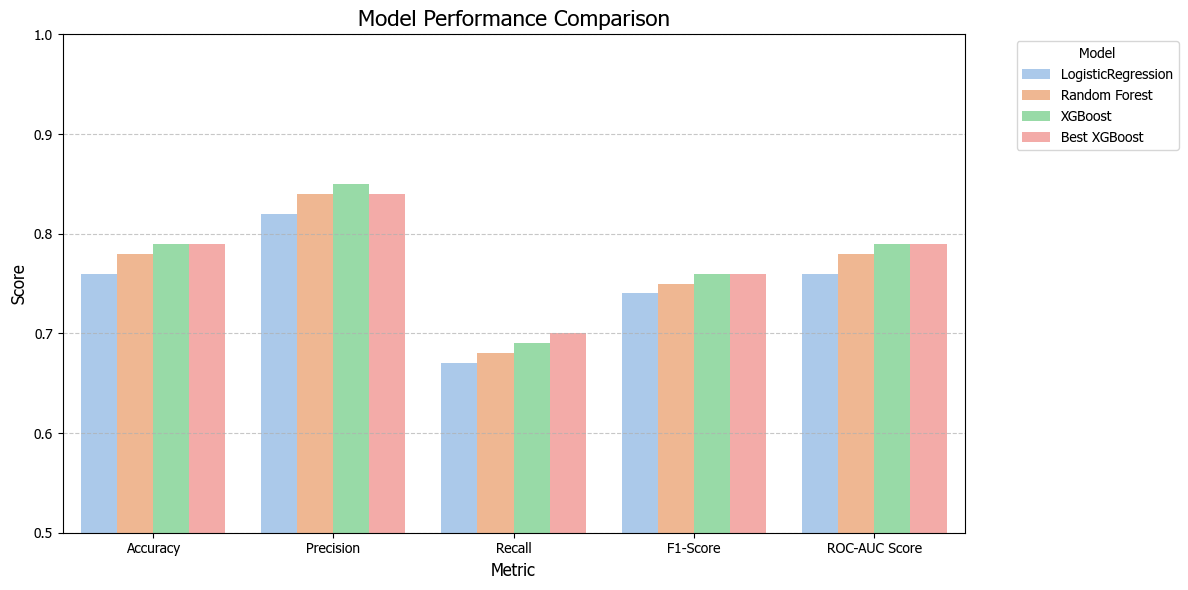

In [91]:
# รวบรวมค่าเมตริกของแต่ละโมเดลในรูปแบบ Dictionary
data = {
    'Accuracy': [0.76,0.78, 0.79, 0.79],
    'Precision': [0.82,0.84, 0.85, 0.84],
    'Recall': [0.67,0.68, 0.69, 0.70],
    'F1-Score': [0.74,0.75, 0.76, 0.76],
    'ROC-AUC Score': [0.76,0.78, 0.79, 0.79]
}

# สร้าง DataFrame จากข้อมูล
df_results = pd.DataFrame(data, index=['LogisticRegression', 'Random Forest', 'XGBoost', 'Best XGBoost'])
df_melted = df_results.reset_index().rename(columns={'index': 'Model'})
df_melted = df_melted.melt(id_vars='Model', 
                           var_name='Metric_Name', 
                           value_name='Score')


plt.figure(figsize=(12, 6))
sns.barplot(x='Metric_Name', y='Score', hue='Model', data=df_melted, palette='pastel')

plt.title('Model Performance Comparison', fontsize=16)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0.5, 1.0) # กำหนดช่วงแกน Y
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

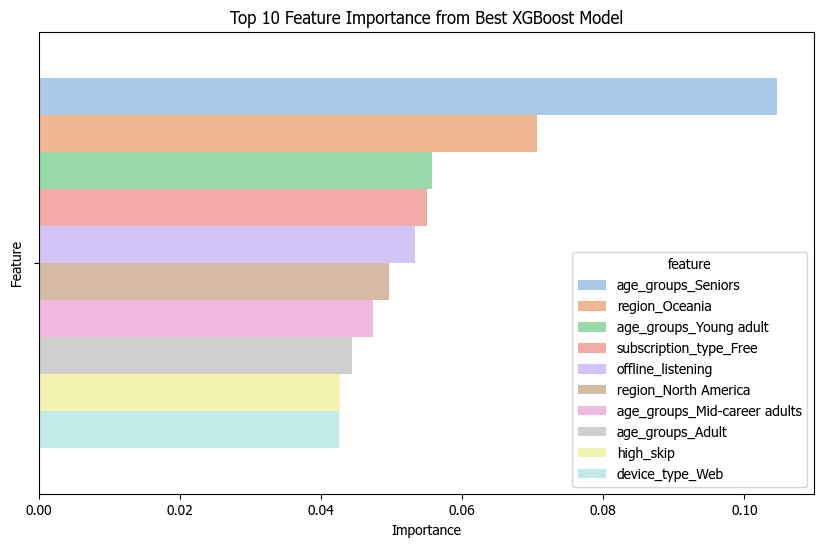

                         feature  importance
27            age_groups_Seniors    0.104688
22                region_Oceania    0.070630
23        age_groups_Young adult    0.055679
15        subscription_type_Free    0.054979
6              offline_listening    0.053301
21          region_North America    0.049664
25  age_groups_Mid-career adults    0.047374
24              age_groups_Adult    0.044409
9                      high_skip    0.042609
19               device_type_Web    0.042507
26       age_groups_Older adults    0.042385
20                 region_Europe    0.041088
18            device_type_Mobile    0.040231
17     subscription_type_Student    0.039441
13                   gender_Male    0.036782
10                 low_listening    0.031175
16     subscription_type_Premium    0.029502
14                  gender_Other    0.027237
7                       high_ads    0.021149
1                            age    0.020696
11                    ads_burden    0.014227
5         

In [93]:
importance = best_xgb_model.feature_importances_ 
features_importance_df = pd.DataFrame({'feature':features_df.columns,'importance':importance}) 
features_importance_df = features_importance_df.sort_values(by='importance',ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', hue='feature', data=features_importance_df.head(10),palette='pastel')
plt.title('Top 10 Feature Importance from Best XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show() 

print(features_importance_df)